# Import necessary libraries
SAFEP_parse.py contains all the functions and library calls necessary to run the notebook
# Required libraries:
- numpy
- pandas
- matplotlib
- alchemlyb (pip install git+https://github.com/alchemistry/alchemlyb)
- natsort (for sorting file names)
- glob (for unix-like file paths)



# IMPORTANT: Make sure the temperature (set below) matches the temperature you used to run the simulations.

In [1]:
import warnings
import logging
import copy
import matplotlib as mpl
from AFEP_parse import *
plt.rcParams['figure.dpi'] = 150

logging.captureWarnings(True)
warnings.simplefilter(action='ignore', category=FutureWarning)
#logger = logging.getLogger("alchemlyb.parsers.NAMD")
logging.disable(level='CRITICAL')

In [2]:
def checkPaths(paths, nDone):
    goodpaths = []
    for path in paths:
        feps = glob(path+pattern)
        countDone = 0
        for fep in feps:
            with open(fep) as f:
                if 'Free' in f.read():
                    countDone+=1
        if countDone == nDone:
            goodpaths.append(path)
    
    return goodpaths

In [22]:
def processLeg(root, prefix, nDone, checkReplicas):
    paths = glob(f'{root}/{prefix}*/')
    if checkReplicas==True:
        paths = checkPaths(paths, nDone)
        
    print(paths)
    u_nks, cumulative, perWindow, affix = batchProcess(paths, RT, decorrelate, pattern, temperature, detectEQ)

    perWindow[('mean', 'df')] = np.mean(perWindow.loc[:, (slice(None), 'df')], axis=1)
    perWindow[('mean', 'ddf')] = np.mean(perWindow.loc[:, (slice(None), 'ddf')], axis=1)
    perWindow[('mean', 'dG_f')] = np.mean(perWindow.loc[:, (slice(None), 'dG_f')], axis=1)
    perWindow[('mean', 'dG_b')] = np.mean(perWindow.loc[:, (slice(None), 'dG_b')], axis=1)

    reps = list(set(perWindow.columns.get_level_values(0)))
    for key in reps:
        perWindow[(key, 'diff')] = perWindow[(key, 'dG_f')]+perWindow[(key, 'dG_b')]

    keys = set(cumulative.columns.get_level_values(0))
    colors = ['#0072B2', '#D55E00', '#CC79A7', '#009E73', '#E69F00']
    keyColors = {}
    i = 0
    for key in keys:
        keyColors[key] = colors[i]
        i += 1
        
    return reps, keyColors, u_nks, cumulative, perWindow, affix

In [23]:
def processAllLegs(root, prefixes, nDone=41, checkReplicas=False):
    meta_unks = {}
    meta_cumulative = {}
    meta_perWindow = {}
    meta_affix = {}
    meta_keyColors = {}
    meta_reps = {}
    feps = np.round(np.linspace(0, 1, nDone),6)
    meta_fs = {}
    meta_bs = {}
    meta_bes = {}
    meta_fes = {}
    for prefix in prefixes:
        if len(glob(root+'/'+prefix+'*/')) > 0:
            reps, keyColors, u_nks, cumulative, perWindow, affix = processLeg(root, prefix, nDone, checkReplicas)

            meta_reps[prefix] = reps
            meta_keyColors[prefix] = keyColors
            meta_unks[prefix] = u_nks
            meta_cumulative[prefix] = cumulative
            meta_perWindow[prefix] = perWindow
            meta_affix[prefix] = affix

            fs = {}
            bs = {}
            fes = {}
            bes = {}

            for l in [x for x in meta_reps[prefix] if x != "mean"]:
                print(f'Doing convergence on {l}')
                u_nks = meta_unks[prefix]
                try:
                    forward, forward_error, backward, backward_error = doConvergence(u_nks[l], feps)
                except:
                    print(f"Failed to doConvergence on {l}")
                    raise
                fs[l] = forward
                fes[l] = forward_error
                bs[l] = backward
                bes[l] = backward_error

            meta_fs[prefix]=fs
            meta_bs[prefix]=bs
            meta_fes[prefix]=fes
            meta_bes[prefix]=bes
    
    return {'unks':meta_unks, 'cumulatives':meta_cumulative, 'perWins':meta_perWindow, 'affixes':meta_affix, 'keyColors':meta_keyColors, 'reps':meta_reps, 'fs':meta_fs, 'bs':meta_bs, 'fes':meta_fs, 'bes':meta_bes}

In [27]:
## Membranes
##root = '/home/ems363/Documents/ELIC_DCDs_Analyses/'
#root = '/home/ezry/winHome/Documents/ELIC_Data/ELIC/'
#systems = ['PCPGPE211', 'PCPG31', 'POPC120']


## Protein systems
#root = '/home/ezry/winHome/Documents/ELIC_Data/'
root = '/home/ems363/Documents/ELIC_DCDs_Analyses/'
systems = ['ELIC5', 'WT']

prefixes = ['pctopg', 'petopc', 'petopg']
longNames = {'pctopg':'POPC to POPG', 'petopc':'POPE to POPC', 'petopg':'POPE to POPG'}

pattern = 'p*fepout'
checkReplicas = False

In [25]:
#glob()
root+systems[1]+prefixes[0]

'/home/ems363/Documents/ELIC_DCDs_Analyses/WTpctopgC'

In [15]:
keep = {'ELIC5':['pctopg6Ed', 'petopc6Ed', 'petopg6Ed'], 'WT':['pctopgC', 'petopcC', 'petopgB']}

In [16]:
temperature = 303.15
RT = 0.00198720650096 * temperature # ca. 0.59kcal/mol
decorrelate = True #Flag for decorrelation of samples
detectEQ = False #Flag for automated equilibrium detection
DiscrepancyFitting = 'LS' #ML = fit PDF of discrepancies with a normal distribution maximum likelihood estimator. LS = fit CDF of discrepancies with a normal distribution least-squares estimator

In [17]:
if False: #Safety
    allSys = {} #separate the proteins in case one fails, we don't lose everything
else:
    print("Did you mean to set the above flag to true?")
    raise

In [29]:
sys = systems[0]
allSys[sys] = processAllLegs(root+sys+'/', prefixes, 121, checkReplicas)

['/home/ems363/Documents/ELIC_DCDs_Analyses/ELIC5/pctopg/']
Reading /home/ems363/Documents/ELIC_DCDs_Analyses/ELIC5/pctopg/
Decorrelating samples. Flag='True'
Doing convergence on pctopg
['/home/ems363/Documents/ELIC_DCDs_Analyses/ELIC5/petopc/']
Reading /home/ems363/Documents/ELIC_DCDs_Analyses/ELIC5/petopc/
Decorrelating samples. Flag='True'
Doing convergence on petopc
['/home/ems363/Documents/ELIC_DCDs_Analyses/ELIC5/petopg/']
Reading /home/ems363/Documents/ELIC_DCDs_Analyses/ELIC5/petopg/
Decorrelating samples. Flag='True'
Doing convergence on petopg


In [28]:
sys = systems[1]
allSys[sys] = processAllLegs(root+sys+'/', prefixes, 121, checkReplicas)

['/home/ems363/Documents/ELIC_DCDs_Analyses/WT/pctopg/']
Reading /home/ems363/Documents/ELIC_DCDs_Analyses/WT/pctopg/
Decorrelating samples. Flag='True'
Doing convergence on pctopg
['/home/ems363/Documents/ELIC_DCDs_Analyses/WT/petopc/']
Reading /home/ems363/Documents/ELIC_DCDs_Analyses/WT/petopc/
Decorrelating samples. Flag='True'
Doing convergence on petopc
['/home/ems363/Documents/ELIC_DCDs_Analyses/WT/petopg/']
Reading /home/ems363/Documents/ELIC_DCDs_Analyses/WT/petopg/
Decorrelating samples. Flag='True'
Doing convergence on petopg


In [55]:
def cumulativePlot(system, leg, keys, keyColors, theax):
    cumulative = system['cumulatives'][leg]
    X = cumulative.index
    for key in keys:
        Y = cumulative[(key, 'f')]*RT
        theColor = keyColors[key]
        theax.plot(X, Y, marker=None, label=key, linewidth=1, color=theColor)
        #finalMean = cumulative.loc[1].iloc[0]*RT
        finalMean = np.mean(cumulative.loc[1, (slice(None), 'f')])
    theax.axhline(finalMean*RT, color='gray', linestyle='-.', linewidth=1)
    
    return theax




def convergencePlot(system, leg, keys, keyColors, theax):
    fs = system['fs'][leg]
    bs = system['bs'][leg]
    for l in [x for x in keys if x != "mean"]:
        theax.plot(np.arange(len(fs[l]))/len(fs[l])+0.1, np.multiply(fs[l], RT), marker='o', linewidth=1, color=keyColors[l], markerfacecolor='white', markeredgewidth=1, markeredgecolor=keyColors[l], ms=5)
        theax.plot(np.arange(len(bs[l]))/len(fs[l])+0.1, np.multiply(bs[l], RT), marker='o', linewidth=1, color=keyColors[l], markerfacecolor='white', markeredgewidth=1, markeredgecolor=keyColors[l], ms=5, linestyle='--')

    theax.xaxis.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    
    cumulative = system['cumulatives'][leg]
    finalMean = np.mean(cumulative.loc[1, (slice(None), 'f')])
    theax.axhline(y= finalMean*RT, linestyle='-.', color='gray')
    theax.plot(0, finalMean*RT, linewidth=1, color='black', label='Forward Time Sampling')
    theax.plot(0, finalMean*RT, linewidth=1, color='black', linestyle='--', label='Backward Time Sampling')

    #theax.legend()
    
    return theax


def hysteresisPlot(system, leg, keys, keyColors, theax):
    perWindow = system['perWins'][leg]
    # Hysteresis plot
    for key in keys:
        #plt.vlines(perWindow.index, np.zeros(len(perWindow)), perWindow[(key, 'dG_f')] + perWindow[(key, 'dG_b')], label=key, linewidth=2)
        theax.plot(perWindow.index, perWindow[(key, 'diff')]*RT, label=key, linewidth=0.5, alpha=0.8, color=keyColors[key])

    theax.plot(perWindow.index, perWindow[('mean', 'diff')]*RT, label='mean', linewidth=1.5, color='black')

    theax.set(ylim=(-1.25, 1.25))

    return theax

    
def hysteresisPDF(system, leg, keys, keyColors, theax):
    
    perWindow = system['perWins'][leg]
    # Hysteresis PDF
    diff = perWindow.loc[:, (slice(None), 'diff')]*RT
    X = diff.drop(columns='mean') #Including the mean in here would underestimate the skewness of the distribution
    Y = np.arange(len(X))/len(X)
    binNum = 20
    pdfY, pdfX = np.histogram(X, bins=binNum, density=True)
    pdfX = (pdfX[1:]+pdfX[:-1])/2


    #plot the data
    theax.plot(pdfX, pdfY,  label="Estimated Distribution")
    theax.set(xlim=(-1.25, 1.25))
    
    return theax

def sharedHystPDF(allSys, systems, leg, colors, theax):
    for sysID in np.arange(len(systems)):
        sysName = systems[sysID]
        print(f'Now making figures for: {sysName}')
        system = allSys[sysName]
        perWindow = system['perWins'][leg]
        # Hysteresis PDF
        diff = perWindow.loc[:, (slice(None), 'diff')]*RT
        X = diff.drop(columns='mean') #Including the mean in here would underestimate the skewness of the distribution
        Y = np.arange(len(X))/len(X)
        binNum = 20
        pdfY, pdfX = np.histogram(X, bins=binNum, density=True)
        pdfX = (pdfX[1:]+pdfX[:-1])/2


        #plot the data
        theax.plot(pdfX, pdfY,  color=colors[sysID], label=sysName)
    theax.set(xlim=(-1.25, 1.25))
    
    return theax

    



def makePlots(allSys, systems, prefixes, xlabel, ylabel, doPlot, sharey=True, sharex=True, sameAx=False, masterColors=['#0072B2', '#D55E00', '#CC79A7', '#009E73', '#E69F00']):
    if sameAx:
        fig, theaxes = plt.subplots(3,1, sharex=sharex, sharey=sharey)
    else:
        fig, theaxes = plt.subplots(3,len(systems), sharex=sharex, sharey=sharey)
    pad = 5 # in points
    
    
    
    
    for prefID in np.arange(len(prefixes)):
        leg = prefixes[prefID]
        if sameAx:
            theaxes[2].set(xlabel=xlabel)
            #theaxes[0].annotate(sysName, xy=(0.5, 1), xytext=(0, pad),
                    #xycoords='axes fraction', textcoords='offset points',
                    #size='large', ha='center', va='baseline')
            theax = doPlot(allSys, systems, leg, masterColors, theaxes[prefID])
            theaxes[prefID].set(ylabel=ylabel)
            theaxes[prefID].annotate(longNames[leg], xy=(0, 0.5), xytext=(-theaxes[prefID].yaxis.labelpad - pad, 0),
                xycoords=theaxes[prefID].yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center', rotation=90)
            theaxes[0].legend()
            
            fig.set_figheight(6)
            fig.set_figwidth(3)
        
        else:
            fig.set_figheight(len(systems)*10.0/3.0)
            fig.set_figwidth(len(systems)*8.0/3)
            for sysID in np.arange(len(systems)):
                
                sysName = systems[sysID]
                system = allSys[sysName]
                print(f'Now making figures for: {sysName}')

                theaxes[2, sysID].set(xlabel=xlabel)
                theaxes[0, sysID].annotate(sysName, xy=(0.5, 1), xytext=(0, pad),
                        xycoords='axes fraction', textcoords='offset points',
                        size='large', ha='center', va='baseline')

                try:
                    keys = system['keyColors'][leg]
                    keyColors = system['keyColors'][leg]

                    theaxes[prefID, 0].set(ylabel=ylabel)
                    theaxes[prefID, 0].annotate(longNames[leg], xy=(0, 0.5), xytext=(-theaxes[prefID, 0].yaxis.labelpad - pad, 0),
                        xycoords=theaxes[prefID, 0].yaxis.label, textcoords='offset points',
                        size='large', ha='right', va='center', rotation=90)
                    theax = doPlot(system, leg, keys, keyColors, theaxes[prefID, sysID])
                except:
                    print("An error occured. Do you have bogus 'replicas'?")
                    raise
                    continue
            

        

    fig.tight_layout()
    
    return fig, theaxes

def colorKey(system, leg, keys, keyColors, theax):
    X = 0
    Y = 0
    width = 0.5
    height = 0.5
    for key in keys:
        print(key)
        if keyColors[key]:
            patch = mpl.patches.Rectangle((X,Y),width, height, edgecolor=keyColors[key], linewidth=None, facecolor=keyColors[key])
            theax.add_patch(patch)
            Y += height
            theax.text(0, Y-height/len(keys), key)
    
    theax.set(ylim=(0,Y), yticks=[], xticks=[])

    return theax


SyntaxError: invalid syntax (2496990210.py, line 23)

In [66]:

def sharedCumulativePlot(allSys, systems, leg, colors, theax):
    for sysID in np.arange(len(systems)):
        sysName = systems[sysID]
        system = allSys[sysName]
        cumulative = system['cumulatives'][leg]
        X = cumulative.index
        
        Y = cumulative[(leg, 'f')]*RT
        theColor = colors[sysID]
        theax.plot(X, Y, marker=None, label=sysName, linewidth=1, color=theColor)
        #finalMean = cumulative.loc[1].iloc[0]*RT
        finalMean = np.mean(cumulative.loc[1, (slice(None), 'f')])
        theax.axhline(finalMean*RT, color=colors[sysID], linestyle='-.', linewidth=1)
    
    return theax

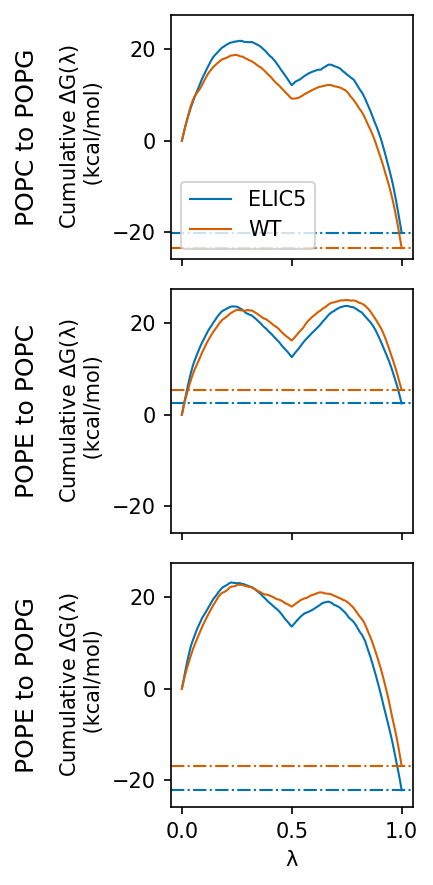

In [68]:
fig, dGaxes = makePlots(allSys, systems, prefixes, xlabel=r'$\rm\lambda$', ylabel=r'Cumulative $\rm\Delta$G($\rm\lambda$)'+'\n (kcal/mol)', doPlot=sharedCumulativePlot, sameAx=True)
plt.savefig(f"{root}/Protein_DRAFT_trimmed_sameAx_S4.pdf")

In [31]:
trimmed=copy.deepcopy(allSys)

Now making figures for: ELIC5
pctopg
Now making figures for: WT
pctopg
Now making figures for: ELIC5
petopc
Now making figures for: WT
petopc
Now making figures for: ELIC5
petopg
Now making figures for: WT
petopg


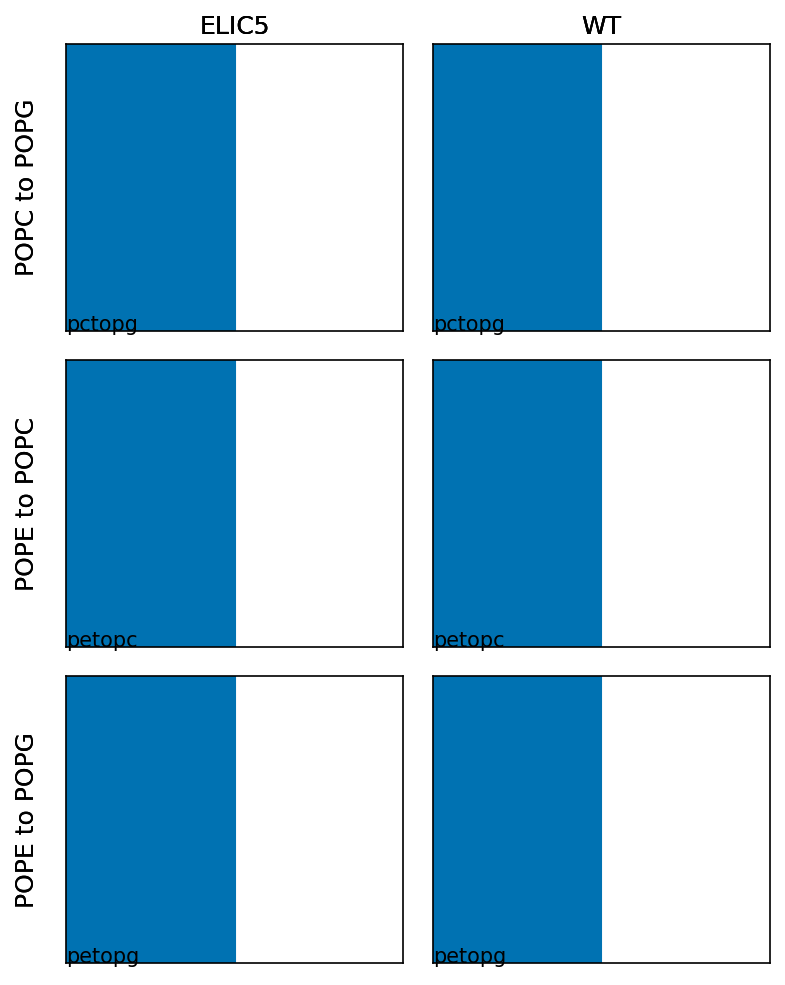

In [32]:
fig, theaxes = makePlots(allSys, systems, prefixes, xlabel=None, ylabel=None, doPlot=colorKey, sharey=False)
plt.savefig(f"{root}/Protein_DRAFT_colorKey.pdf")

Now making figures for: ELIC5
Now making figures for: WT
Now making figures for: ELIC5
Now making figures for: WT
Now making figures for: ELIC5
Now making figures for: WT


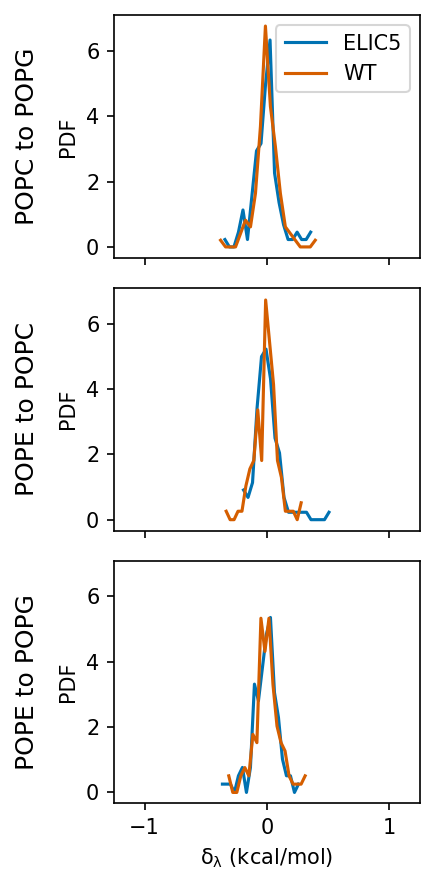

In [69]:
fig, theaxes = makePlots(allSys, systems, prefixes, xlabel=r'$\rm\delta_{\lambda}$ (kcal/mol)', ylabel='PDF', doPlot=sharedHystPDF, sharey=True, sameAx=True)
plt.savefig(f"{root}/Protein_DRAFT_trimmed_S3.pdf")

Now making figures for: ELIC5
Now making figures for: WT
Now making figures for: ELIC5
Now making figures for: WT
Now making figures for: ELIC5
Now making figures for: WT


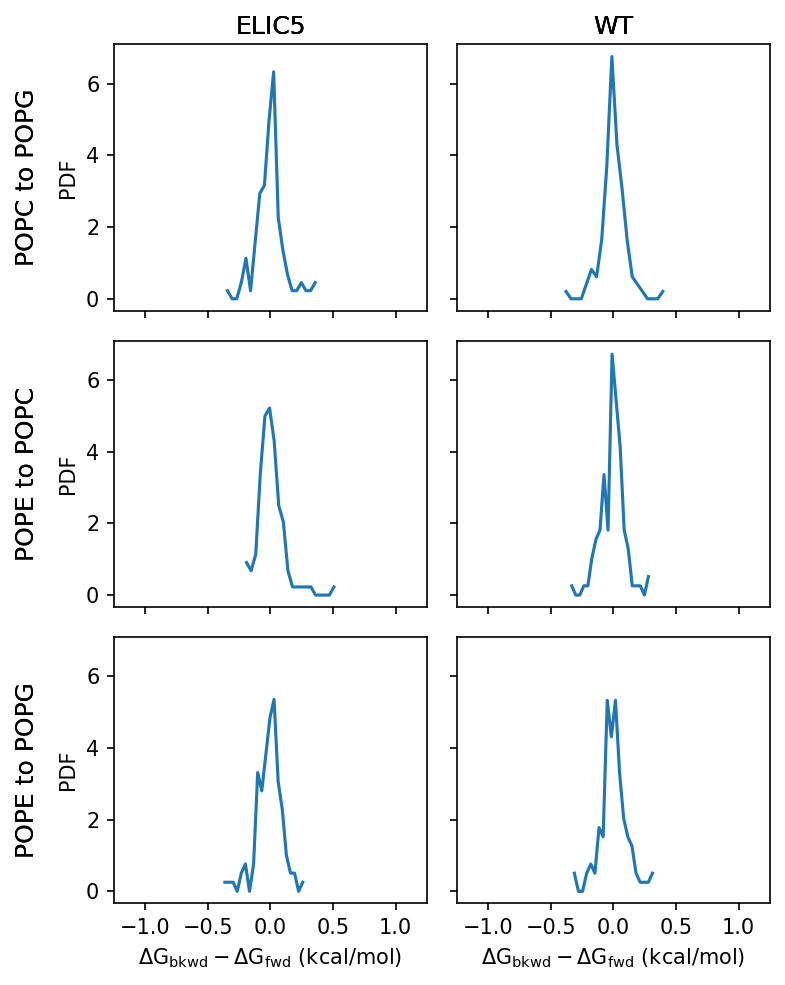

In [34]:
fig, theaxes = makePlots(allSys, systems, prefixes, xlabel=r'$\rm\Delta G_{bkwd}-\Delta G_{fwd}$ (kcal/mol)', ylabel='PDF', doPlot=hysteresisPDF, sharey=True)
plt.savefig(f"{root}/Protein_DRAFT_trimmed_S3.pdf")

Now making figures for: ELIC5
Now making figures for: WT
Now making figures for: ELIC5
Now making figures for: WT
Now making figures for: ELIC5
Now making figures for: WT


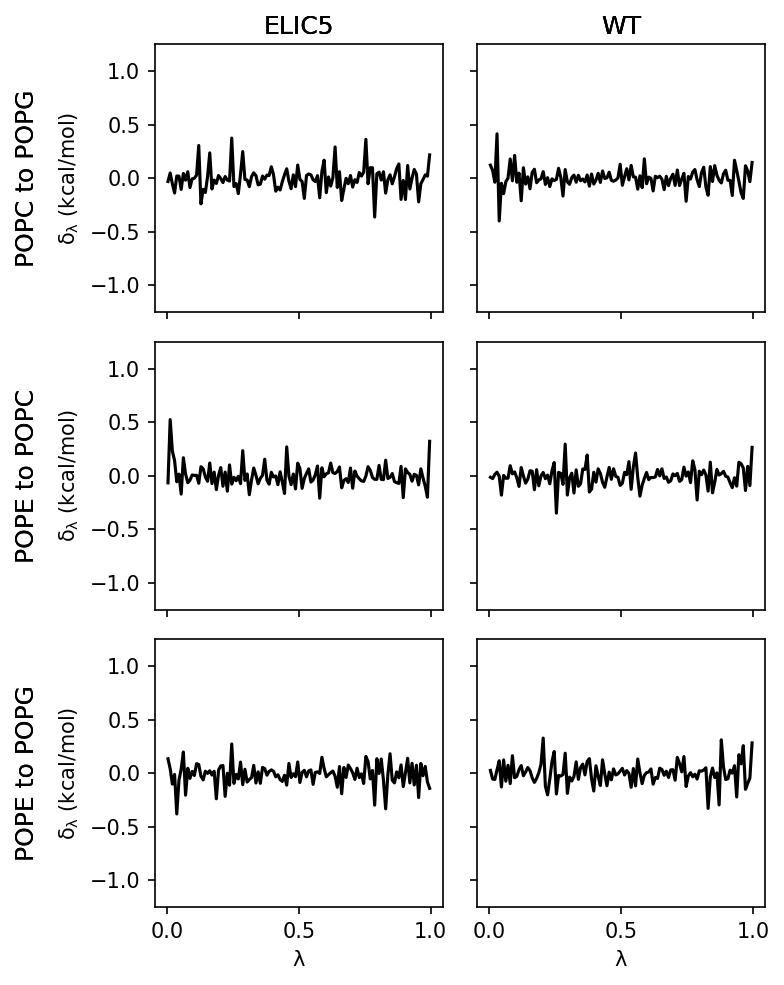

In [35]:
fig, theaxes = makePlots(allSys, systems, prefixes, xlabel=r'$\rm\lambda$', ylabel=r'$\rm\delta_{\lambda}$ (kcal/mol)', doPlot=hysteresisPlot, sharey='row')
plt.savefig(f"{root}/Protein_DRAFT_altYLabel_S2.pdf")

Now making figures for: ELIC5
Now making figures for: WT
Now making figures for: ELIC5
Now making figures for: WT
Now making figures for: ELIC5
Now making figures for: WT


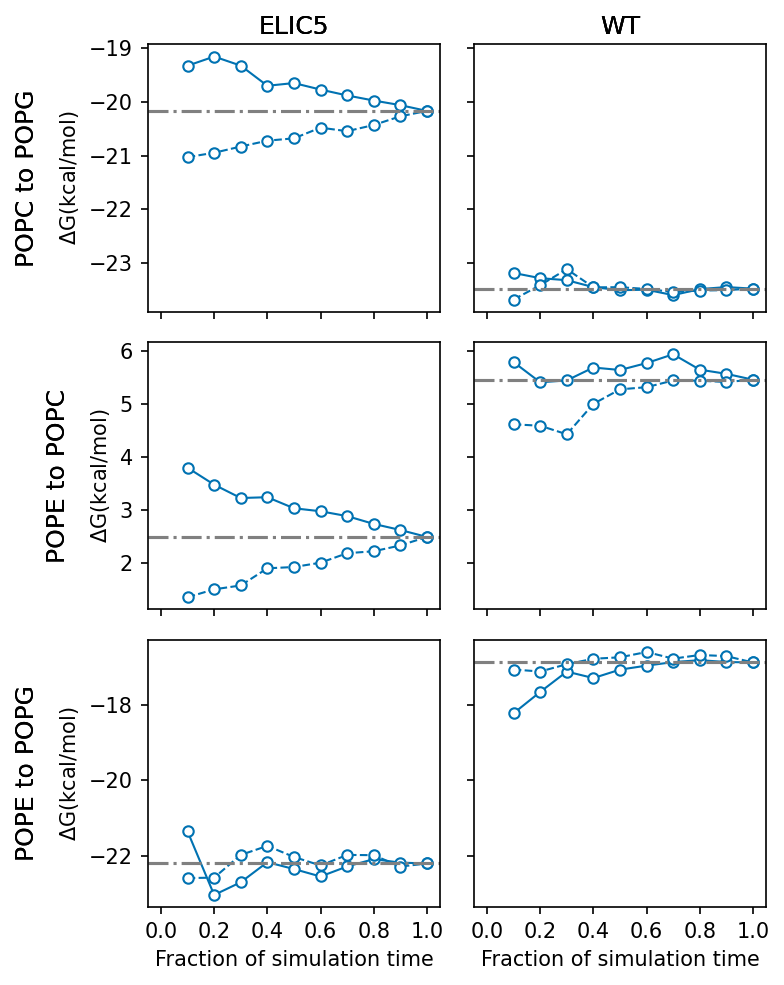

In [36]:
fig, theaxes = makePlots(allSys, systems, prefixes, xlabel='Fraction of simulation time', ylabel=r'$\rm\Delta G (kcal/mol)$', doPlot=convergencePlot, sharey='row')
plt.savefig(f"{root}/Protein_DRAFT_trimmed_S1.pdf")

Now making figures for: ELIC5
Now making figures for: WT
Now making figures for: ELIC5
Now making figures for: WT
Now making figures for: ELIC5
Now making figures for: WT


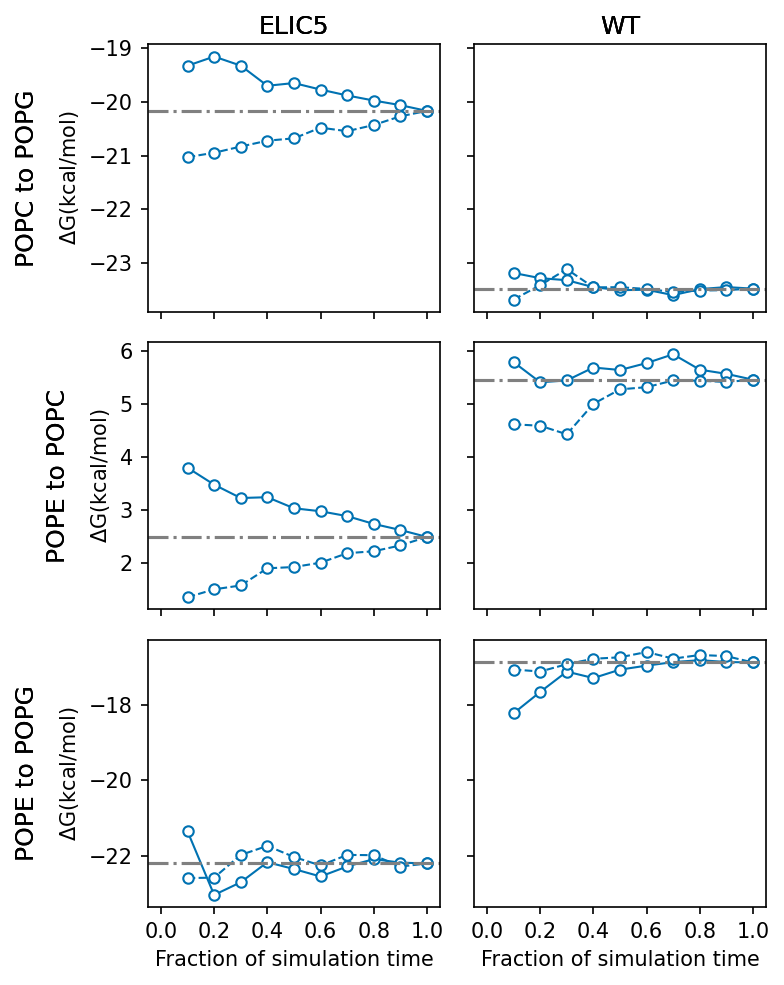

In [36]:
fig, theaxes = makePlots(allSys, systems, prefixes, xlabel='Fraction of simulation time', ylabel=r'$\rm\Delta G (kcal/mol)$', doPlot=convergencePlot, sharey='row')
plt.savefig(f"{root}/Protein_DRAFT_trimmed_S1.pdf")

Now making figures for: ELIC5
Now making figures for: WT
Now making figures for: ELIC5
Now making figures for: WT
Now making figures for: ELIC5
Now making figures for: WT


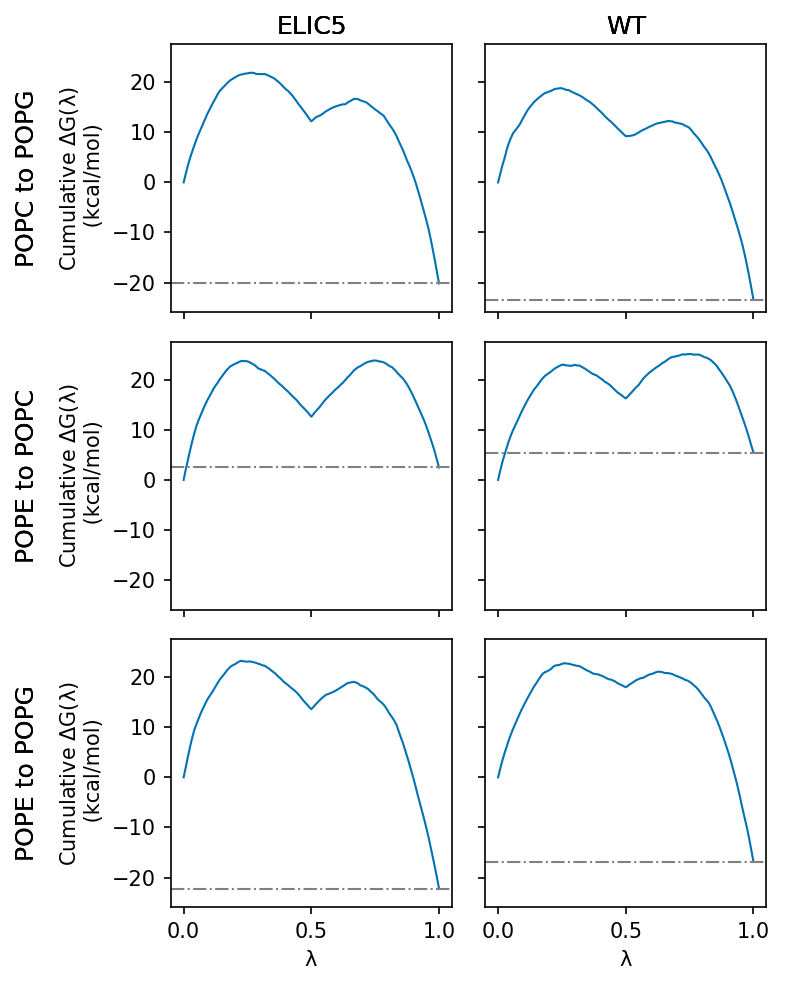

In [41]:
fig, dGaxes = makePlots(allSys, systems, prefixes, xlabel=r'$\rm\lambda$', ylabel=r'Cumulative $\rm\Delta$G($\rm\lambda$)'+'\n (kcal/mol)', doPlot=cumulativePlot)
plt.savefig(f"{root}/Protein_DRAFT_trimmed_S4.pdf")